<a href="https://colab.research.google.com/github/Sergius-DS/Pytorch/blob/main/Lkd_Pytorch_MULTICLASS_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 88

FUNCIÓN PARA VISUALIZAR BORDES DE LAS DIFERENTES CATEGORÍAS

In [2]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:,0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:,1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
      y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
      y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    else:
      y_pred = torch.round(torch.sigmoid(y_logits))

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:,0], X[:,1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

In [3]:
#Set up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

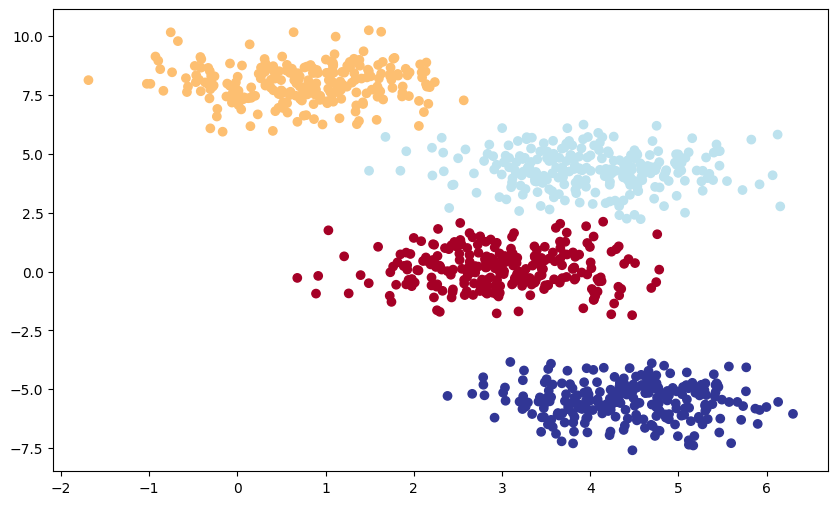

In [4]:
#create multiclass data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=0.8,
                            random_state=RANDOM_SEED)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

plt.figure(figsize=(10,6))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)

In [5]:
#Create
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """Initializes multiclass model"""
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)


model_2 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)
model_2

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [6]:
#create a loss function
loss_fn = nn.CrossEntropyLoss()

#create an optimizer
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.1)

In [7]:
"""building a training loop to evaluate and train,
test model. Convert output(logits) to prediction probabilities,
then to prediction labels with an ACTIVATION FUNCTION"""

model_2.eval()
with torch.inference_mode():
  y_logits = model_2(X_blob_test.to(device))

y_logits[:11]

tensor([[-0.5751, -0.9687, -0.1341,  0.9498],
        [-0.0162, -0.2856,  0.0102,  0.3750],
        [-0.0925, -0.4169,  0.1835,  0.4251],
        [-0.7049, -0.8747, -0.1584,  0.9290],
        [ 0.0571, -0.3011,  0.0848,  0.3316],
        [-0.4351, -0.6428, -0.0095,  0.6969],
        [-0.4097,  0.1511, -0.6692,  0.5775],
        [-0.5446, -0.7001, -0.0734,  0.7802],
        [-0.4764,  0.2544, -0.8563,  0.6194],
        [-0.6972, -0.8322, -0.1548,  0.9088],
        [-0.1992, -0.3068,  0.0940,  0.4668]], device='cuda:0')

In [8]:
X_blob_test.device

device(type='cpu')

In [9]:
y_pred_probs = torch.softmax(y_logits, dim=1)

In [10]:
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.5751, -0.9687, -0.1341,  0.9498],
        [-0.0162, -0.2856,  0.0102,  0.3750],
        [-0.0925, -0.4169,  0.1835,  0.4251],
        [-0.7049, -0.8747, -0.1584,  0.9290],
        [ 0.0571, -0.3011,  0.0848,  0.3316]], device='cuda:0')
tensor([[0.1278, 0.0862, 0.1987, 0.5873],
        [0.2342, 0.1789, 0.2405, 0.3464],
        [0.2119, 0.1532, 0.2793, 0.3556],
        [0.1150, 0.0971, 0.1986, 0.5893],
        [0.2473, 0.1729, 0.2543, 0.3255]], device='cuda:0')


In [11]:
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0')

In [12]:
torch.max(y_pred_probs[0])

tensor(0.5873, device='cuda:0')

In [13]:
print(y_pred_probs[:5])

tensor([[0.1278, 0.0862, 0.1987, 0.5873],
        [0.2342, 0.1789, 0.2405, 0.3464],
        [0.2119, 0.1532, 0.2793, 0.3556],
        [0.1150, 0.0971, 0.1986, 0.5893],
        [0.2473, 0.1729, 0.2543, 0.3255]], device='cuda:0')


In [14]:
torch.argmax(y_pred_probs[0])#[0.5218:POSITION 0, 0.2054:POSITION 1, 0.1126:POSITION 2, 0.1601:POSITION 3]

tensor(3, device='cuda:0')

In [15]:
#convert model's prediction probabilities to predictions labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')

In [16]:
y_blob_test

tensor([2, 0, 0, 2, 0, 2, 3, 2, 3, 2, 0, 1, 3, 1, 3, 3, 0, 0, 3, 0, 2, 0, 0, 2,
        3, 2, 2, 1, 2, 1, 0, 0, 1, 0, 3, 0, 0, 2, 2, 3, 1, 0, 0, 3, 0, 3, 2, 1,
        3, 2, 1, 0, 2, 1, 3, 1, 3, 2, 2, 0, 3, 1, 1, 3, 3, 0, 0, 3, 2, 1, 3, 1,
        0, 3, 1, 3, 0, 3, 0, 1, 0, 3, 3, 2, 0, 3, 2, 0, 1, 3, 0, 0, 3, 0, 2, 0,
        2, 2, 3, 1, 2, 3, 3, 2, 3, 0, 0, 1, 3, 2, 2, 0, 2, 2, 1, 1, 0, 2, 3, 0,
        3, 0, 2, 2, 0, 2, 1, 2, 1, 0, 2, 3, 0, 2, 0, 0, 0, 3, 3, 2, 0, 2, 3, 3,
        2, 3, 2, 1, 1, 3, 0, 2, 2, 1, 2, 2, 3, 0, 0, 2, 3, 2, 2, 1, 2, 2, 3, 2,
        3, 2, 0, 1, 2, 0, 0, 3, 0, 2, 3, 2, 2, 3, 0, 2, 1, 1, 1, 3, 3, 1, 1, 1,
        1, 3, 2, 3, 2, 2, 3, 3])

In [17]:
#Build a function for printing Accuracy Score
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

#create a training and testing loop for our multiclass
torch.manual_seed(88)
torch.cuda.manual_seed(88)

epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
  model_2.train()
  y_logits = model_2(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  #testing
  model_2.eval()
  with torch.inference_mode():
    test_logits = model_2(X_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,
                           y_pred=test_preds)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f} | Acc: {acc:.4f}% | Test Loss: {test_loss:.4f} | Test Acc. {test_acc:.2f}%")

Epoch: 0 | Loss: 1.7272 | Acc: 24.5000% | Test Loss: 1.0725 | Test Acc. 56.50%
Epoch: 10 | Loss: 0.2354 | Acc: 98.1250% | Test Loss: 0.2615 | Test Acc. 98.50%
Epoch: 20 | Loss: 0.0937 | Acc: 98.6250% | Test Loss: 0.1042 | Test Acc. 99.00%
Epoch: 30 | Loss: 0.0448 | Acc: 98.8750% | Test Loss: 0.0512 | Test Acc. 99.00%
Epoch: 40 | Loss: 0.0258 | Acc: 99.2500% | Test Loss: 0.0377 | Test Acc. 99.50%
Epoch: 50 | Loss: 0.0166 | Acc: 99.7500% | Test Loss: 0.0226 | Test Acc. 99.50%
Epoch: 60 | Loss: 0.0124 | Acc: 99.8750% | Test Loss: 0.0113 | Test Acc. 100.00%
Epoch: 70 | Loss: 0.0102 | Acc: 99.8750% | Test Loss: 0.0076 | Test Acc. 100.00%
Epoch: 80 | Loss: 0.0088 | Acc: 99.8750% | Test Loss: 0.0060 | Test Acc. 100.00%
Epoch: 90 | Loss: 0.0078 | Acc: 99.8750% | Test Loss: 0.0050 | Test Acc. 100.00%


In [18]:
test_logits.shape

torch.Size([200, 4])

In [19]:
y_blob_test.shape

torch.Size([200])

In [20]:
#making predictions and evaluating
model_2.eval()
with torch.inference_mode():
  y_logits = model_2(X_blob_test)

y_logits[:8]

tensor([[  -1.3528,   -1.0053,    4.1684,   -1.7877],
        [  18.4730,  -26.4904,  -20.9650,   -5.2974],
        [   4.2224,   -6.9433,   -1.4382,   -3.1720],
        [  -1.3528,   -1.0053,    4.1684,   -1.7877],
        [  15.7578,  -29.1448,  -25.0677,   -3.0882],
        [  -1.3528,   -1.0053,    4.1684,   -1.7877],
        [  -8.0125, -112.4294, -134.6846,   25.0842],
        [  -1.3528,   -1.0053,    4.1684,   -1.7877]], device='cuda:0')

In [21]:
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:8]

tensor([[3.9524e-03, 5.5949e-03, 9.8789e-01, 2.5586e-03],
        [1.0000e+00, 2.9692e-20, 7.4526e-18, 4.7492e-11],
        [9.9591e-01, 1.4094e-05, 3.4663e-03, 6.1219e-04],
        [3.9524e-03, 5.5949e-03, 9.8789e-01, 2.5586e-03],
        [1.0000e+00, 3.1553e-20, 1.8609e-18, 6.5355e-09],
        [3.9524e-03, 5.5949e-03, 9.8789e-01, 2.5586e-03],
        [4.2294e-15, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [3.9524e-03, 5.5949e-03, 9.8789e-01, 2.5586e-03]], device='cuda:0')

In [22]:
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:8]

tensor([2, 0, 0, 2, 0, 2, 3, 2], device='cuda:0')

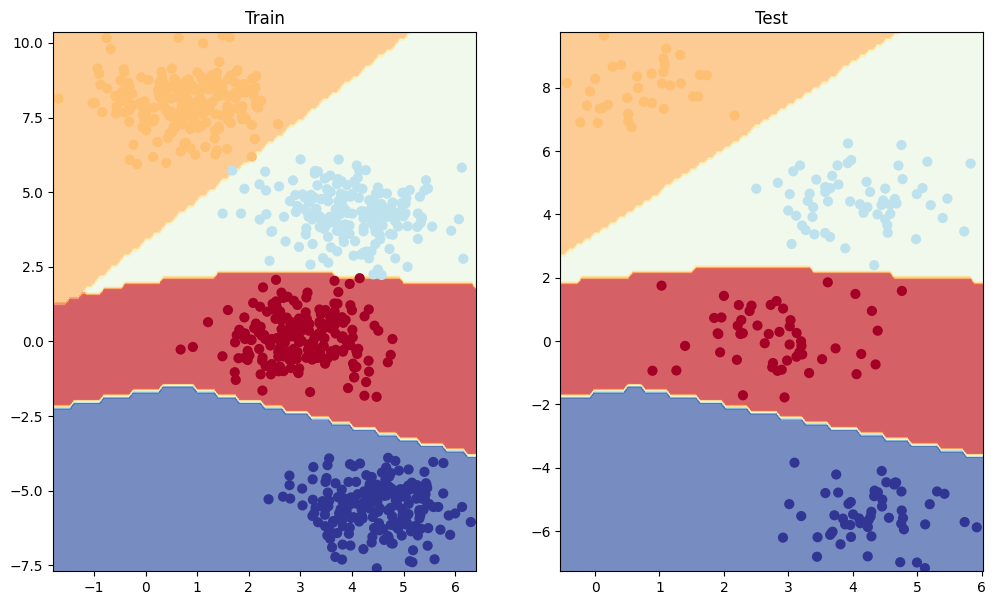

In [23]:
#Plotting Decision Boundary for Multiclass issue
plt.figure(figsize=(12,7))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_2, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_2, X_blob_test, y_blob_test)
plt.show()

In [24]:
#INSTALL torchmetrics
!pip install torchmetrics

In [25]:
#Print Accuracy of MODEL PREDICTIONS
from torchmetrics import Accuracy

torch_metric_accuracy = Accuracy(task="multiclass", num_classes=4).to(device)

torch_metric_accuracy(y_preds, y_blob_test)

tensor(1., device='cuda:0')